In [1]:
import numpy as np
from matplotlib import pyplot as plt

from filters import UnscentedKalmanFilter as UKF
from utils import (
    load_imu_data,
    generate_radar_measurement_data,
    run_radar_position_estimation,
    run_euler_attitude_estimation,
    plot_xyz,
    plot_radar_result,
    plot_measurement_vs_estimation,
)

In [2]:
# Testing sigma points and UT
xm = np.array([[1, 2, 3]]).T
Px = np.array([[1, 0.1, 0.1, 0.1, 1, 0.1, 0.1, 0.1, 1]]).reshape(3, 3)
kappa = 2

chi, W = UKF.sigma_points(xm, Px, kappa)

xm2, Px2 = UKF.UT(chi, W)

assert np.allclose(xm, xm2)
assert np.allclose(Px, Px2)

# 예제 1 : 레이다 추적

In [3]:
class RadarUKF(UKF):
    def __init__(self, dt, x0, P0, Q, R, **kwargs):
        super().__init__(x0, P0, Q, R, **kwargs)
        self.dt = dt
        
    def f(self, x):
        A = np.eye(3) + dt * np.array([0, 1, 0, 0, 0, 0, 0, 0, 0]).reshape(3, 3)
        return A @ x
    
    def h(self, x):
        x1, x2, x3 = x
        return ((x1**2 + x3**2)**0.5)[None]

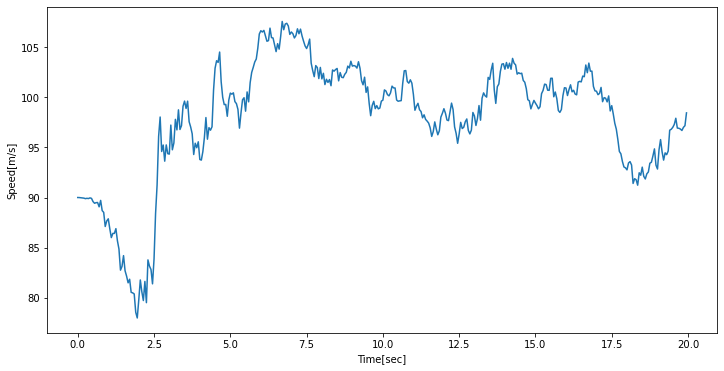

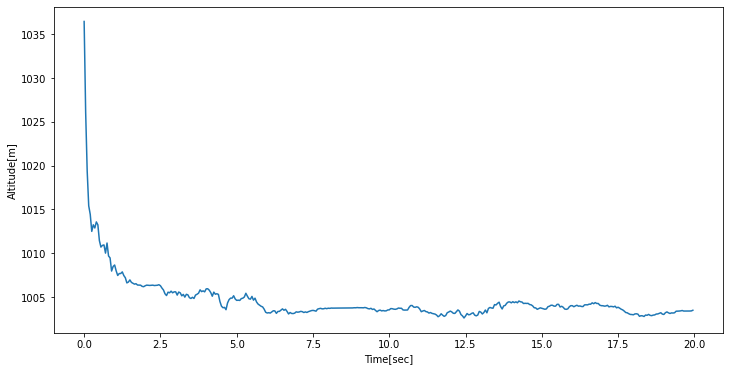

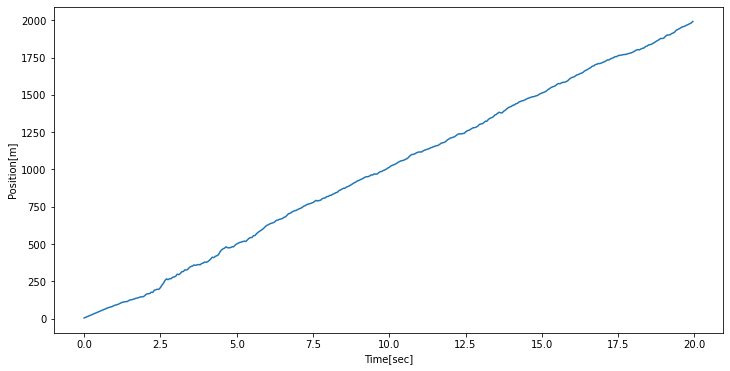

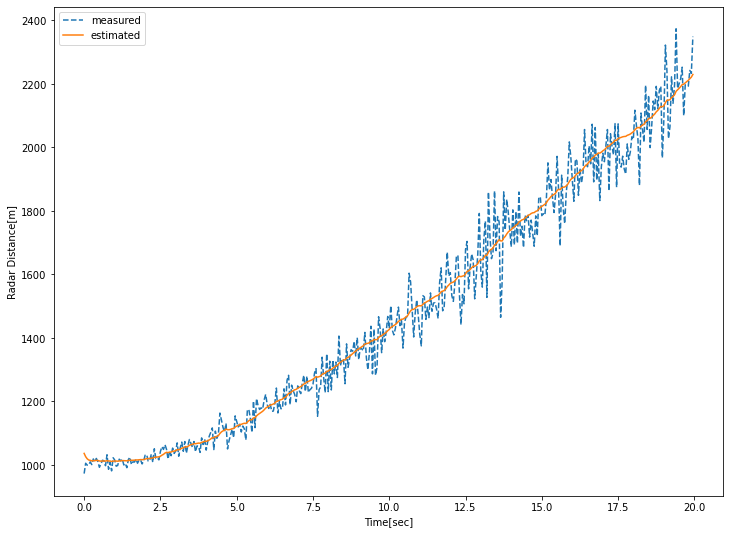

In [4]:
dt = 0.05
ts = np.arange(0, 20, dt)

ukf = RadarUKF(
    dt = dt,
    x0 = np.array([[0, 90, 1100]]).T,
    P0 = np.eye(3) * 100,
    Q = np.array([0.01, 0, 0, 
                  0, 0.01, 0,
                  0, 0, 0.01]).reshape(3, 3),
    R = 100
)

measurements, estimations, speeds, altitudes, positions = run_radar_position_estimation(
    ukf, ts, generate_radar_measurement_data(dt)
)
plot_radar_result(ts, speeds, altitudes, positions)
plot_measurement_vs_estimation(ts, measurements, estimations, "Radar Distance[m]")

# 예제 2 : 기울기 자세 측정하기

In [5]:
class EulerUKF(UKF):
    def __init__(self, dt, x0, P0, Q, R, **kwargs):
        super().__init__(x0, P0, Q, R, **kwargs)
        self.dt = dt
        self.gyro = None
        
    def f(self, x):
        p, q, r = self.gyro
        phi, theta, _ = x
        
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)
        tan_theta = np.tan(theta)
        sec_theta = 1 / np.cos(theta)
        
        xdot = np.stack([
            p + q * sin_phi * tan_theta + r * cos_phi * tan_theta,
                q * cos_phi             - r * sin_phi,
                q * sin_phi * sec_theta + r * cos_phi * sec_theta,
        ])
        return x + dt * xdot
    
    def h(self, x):
        return x[:2, ...]

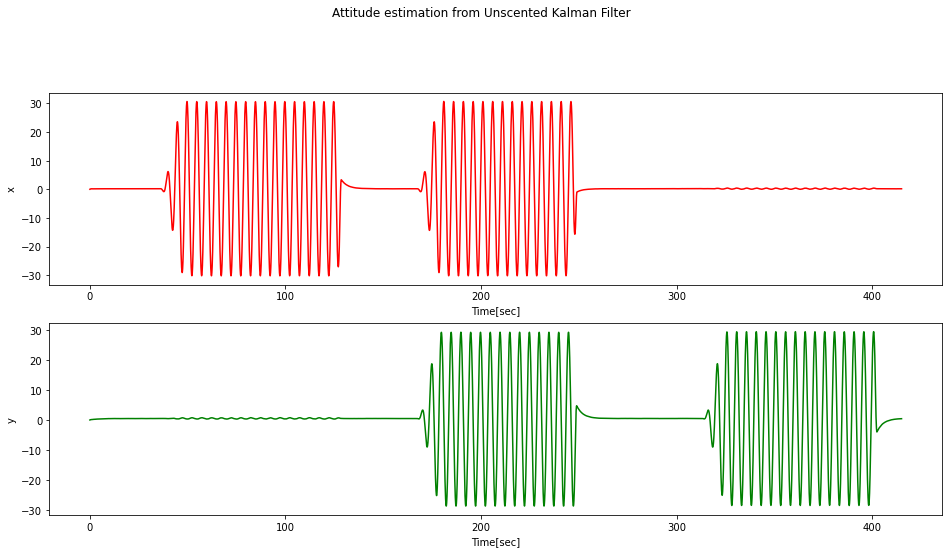

In [6]:
dt, ts, gyro, acce = load_imu_data()

ukf = EulerUKF(
    dt = dt,
    x0 = np.array([[0, 0, 0]]).T,
    P0 = np.eye(3) * 1,
    Q = np.array([[0.0001, 0, 0],
                  [0, 0.0001, 0],
                  [0, 0, 0.1]]),
    R = np.eye(2) * 10
)

euler_estimations = run_euler_attitude_estimation(ukf, ts, gyro, acce)
plot_xyz(ts, euler_estimations, "Attitude estimation from Unscented Kalman Filter")